## Validation of the 2D ray-rectangle intersection calculation

### imports

In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Read in the configuration, should be tested by `get_config.ipynb`

In [2]:
config = pymatcal.get_config('test-config.yml')
print(config['dist'])

60.0


### Define point $A$ in FOV for debugging

In [3]:
pointA = np.array([5, 3, 0])
angle_deg = 10

### Setup subdivisions and $p_A p_B$ pairs

In [4]:
det_subdivs = pymatcal.get_det_subdivs(
    config['active det'][0], config['det nsub'])
img_subdivs = pymatcal.get_img_subdivs(config['mmpvx'], config['img nsub'])

pAs = img_subdivs['coords']+pointA
# pBs = det_subdivs['coords']+np.array([config['dist'], 0, 0])
pBs = pymatcal.get_centroids(det_subdivs['geoms'])

pAs = pymatcal.coord_transform(
    pymatcal.get_mtransform(angle_deg, -config['dist'], 5), pAs)
abpairs = pymatcal.get_AB_pairs(pAs, pBs)

### Set blocking detector units array and the focused detector unit

In [5]:
blocks = config["det geoms"][config["det geoms"][:,6] != config["active det"][0][6]]
focus_det = np.array([config["active det"][0]])
print(blocks.shape,focus_det.shape)

(3, 8) (1, 8)


### Test on the intersects calculation. 
*Note: the intersects coordinates are only for debugging and plotting purpose*

1. Calculate the corresponding intersections on blocking detector units and on the focused detector unit 

In [6]:

intersects_blk = pymatcal.get_intersects_2d(blocks,abpairs)
intersects_det = pymatcal.get_intersects_2d(focus_det,abpairs)

2. Plot intersects and rays

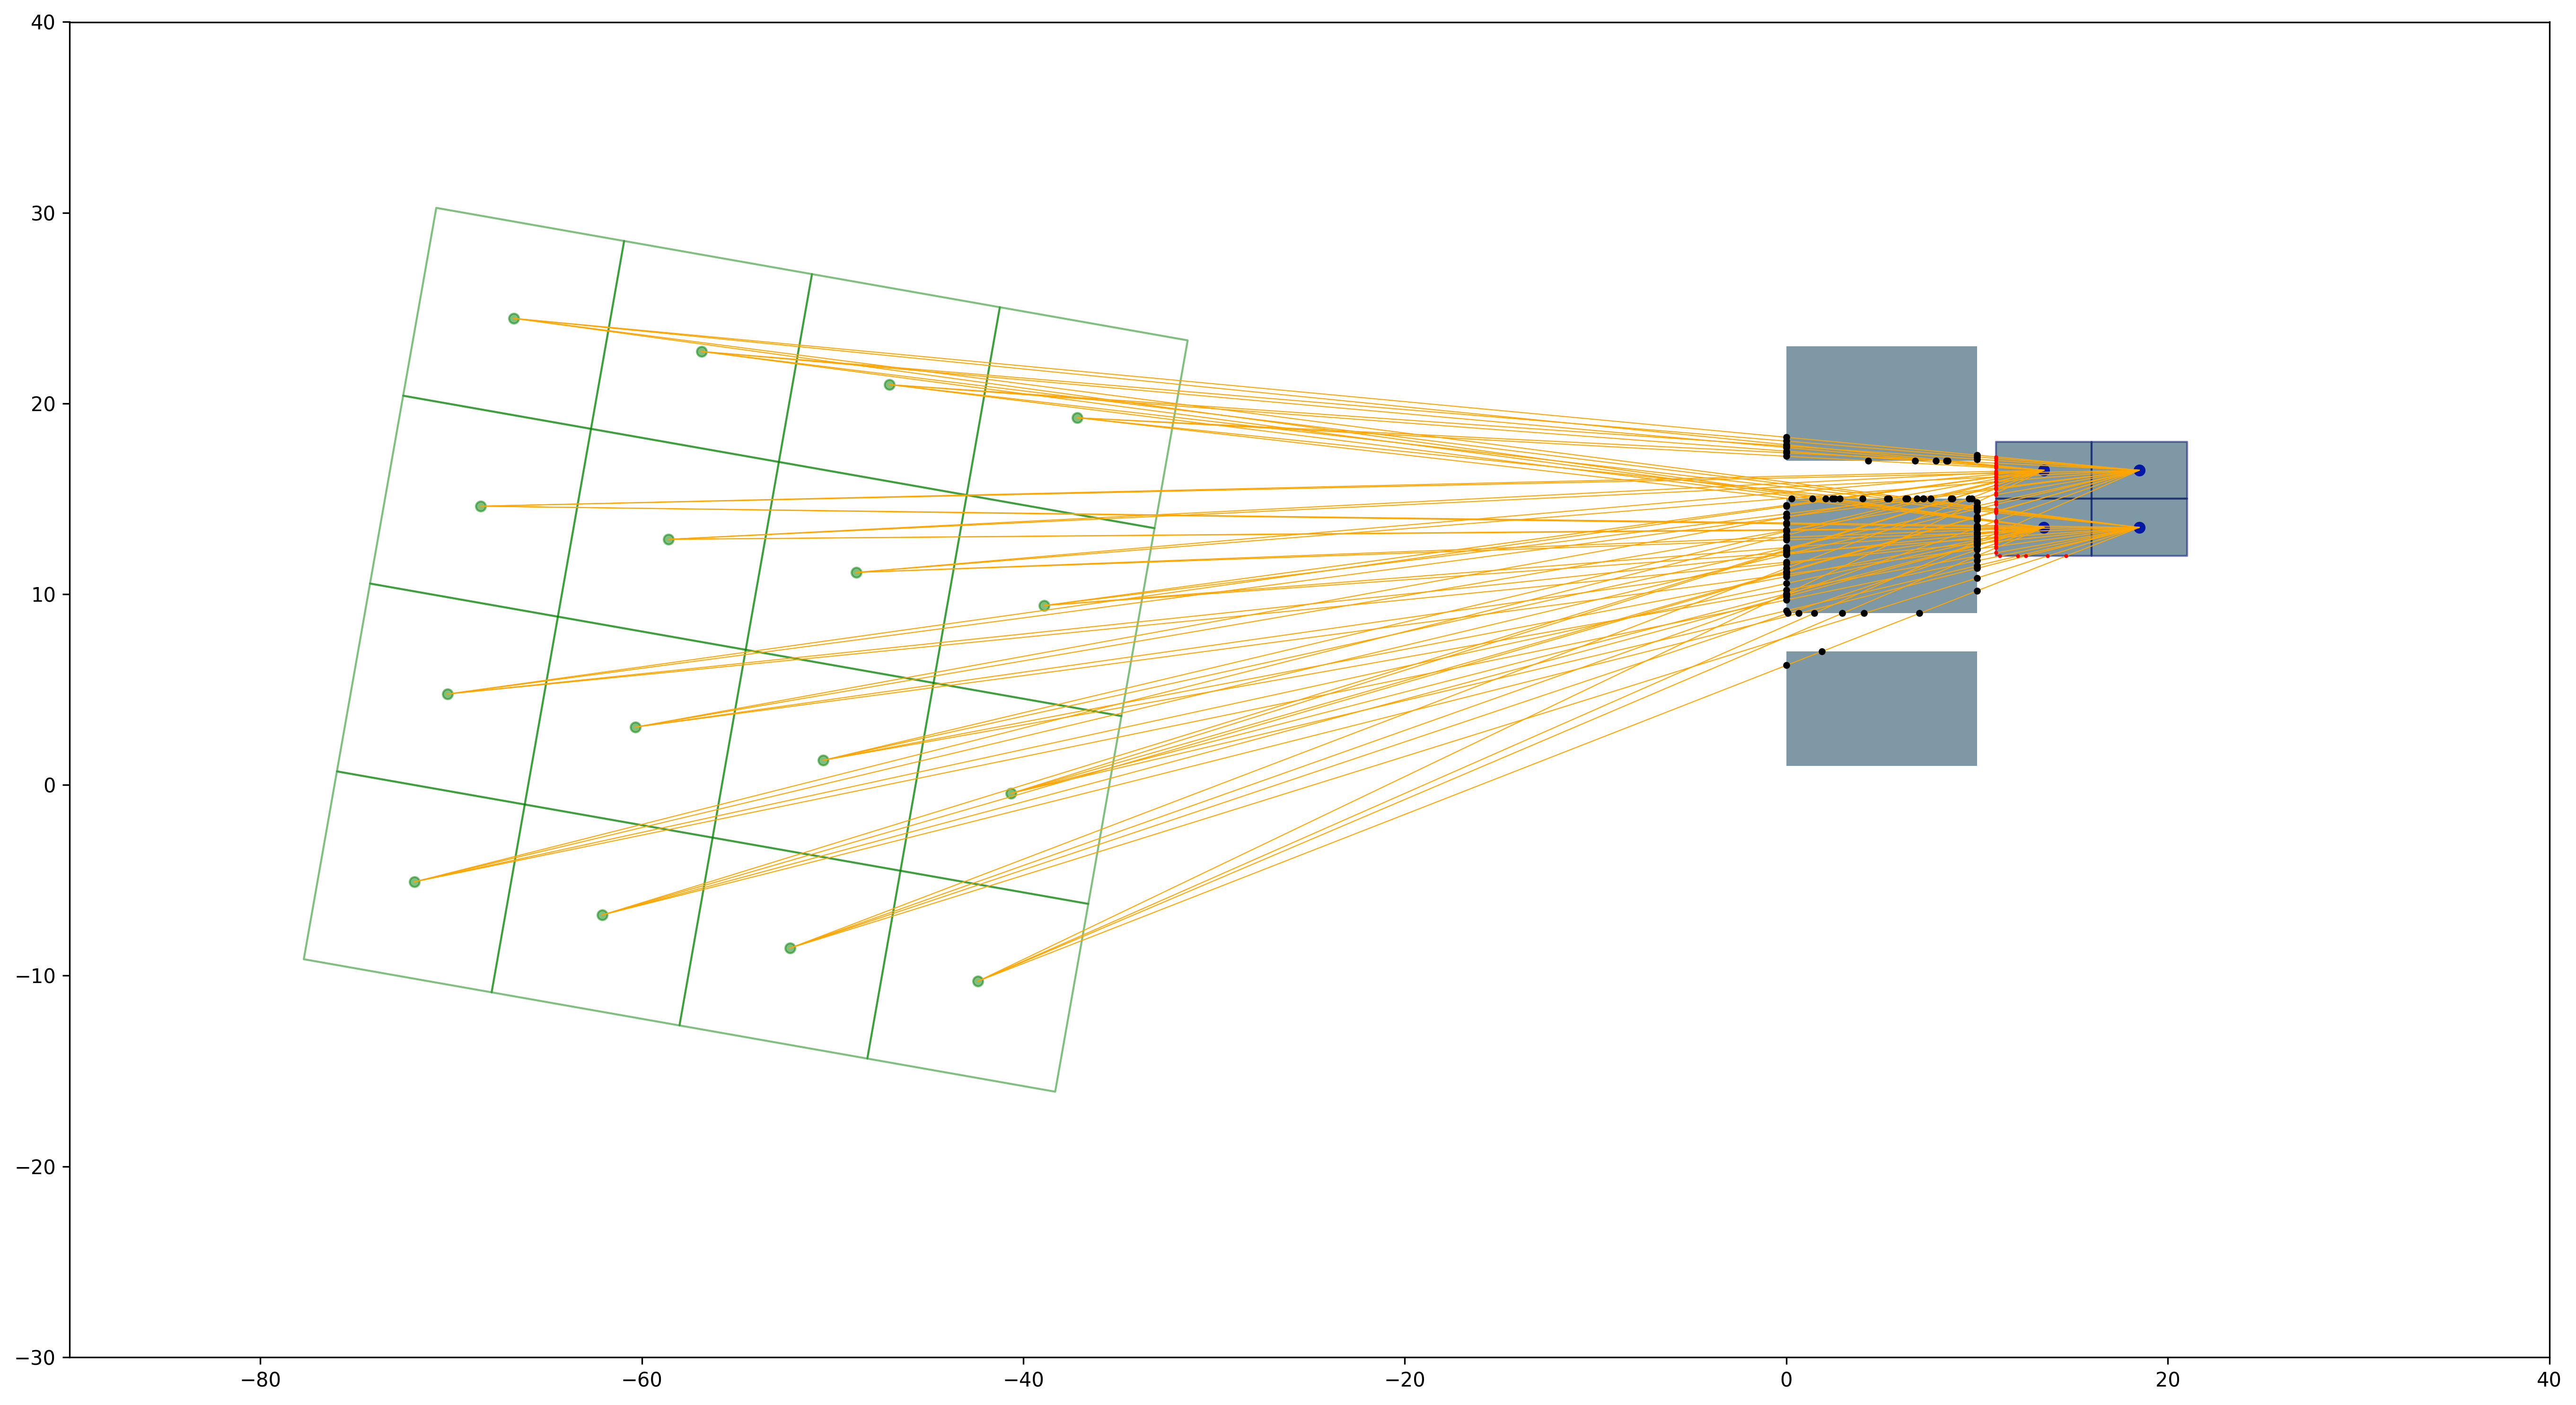

In [7]:
det_subdiv_list = [
    mpl.patches.Rectangle(
        xy[:2] - det_subdivs["incs"][:2] * 0.5,
        det_subdivs["incs"][0],
        det_subdivs["incs"][1],
    )
    for xy in pBs
]
subdiv_inc = np.array(
    [
        config["mmpvx"][0] / config["img nsub"][0],
        config["mmpvx"][1] / config["img nsub"][1],
    ]
)
img_subdiv_list = [
    mpl.patches.Rectangle(
        xy - subdiv_inc * 0.5,
        subdiv_inc[0],
        subdiv_inc[1],
        angle=-angle_deg,
        rotation_point=(xy[0],xy[1])
    )
    for xy in pAs[:, :2]
]

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
pc = mpl.collections.PatchCollection(img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="none")
pc1 = mpl.collections.PatchCollection(det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc="none")
idx = 0
# passIndx = np.all(np.all(ts == 0, axis=2),axis=0)

# for pair in abpairs[passIndx]:
for pair in abpairs:
    ax.plot(pair[0::3], pair[1::3], ",-", c="orange", ms=10, lw=0.5,zorder=12)
    idx += 1

block_list = [
    mpl.patches.Rectangle((geom[0], geom[2]), geom[1] - geom[0], geom[3] - geom[2])
    for geom in config["det geoms"]
]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0, 0.2, 0.3, 0.5), ec="none", zorder=10
)
ax.add_collection(pc2)
ax.plot(pAs[:, 0], pAs[:, 1], ".", color=(0, 0.5, 0, 0.5), ms=10)
ax.plot(pBs[:, 0], pBs[:, 1], ".", color=(0, 0, 1, 1), ms=10)
pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
ax.set_xlim(-90, 40)
ax.set_ylim(-30, 40)

ax.add_collection(pc)
ax.add_collection(pc1)

ax.set_aspect("equal")
for idx in [0, 1]:
    ax.plot(intersects_blk[:, 0, idx], intersects_blk[:, 1, idx], "k.", ms=5,zorder=13)
ax.plot(intersects_det[:, 0, 0], intersects_det[:, 1, 0], "r.", ms=2, zorder=15)
fig.tight_layout()
# fig.savefig("intersection-2d_1.png", dpi=300)

3. Plot only rays passing through openings. 
Decision is based on $t$ numbers

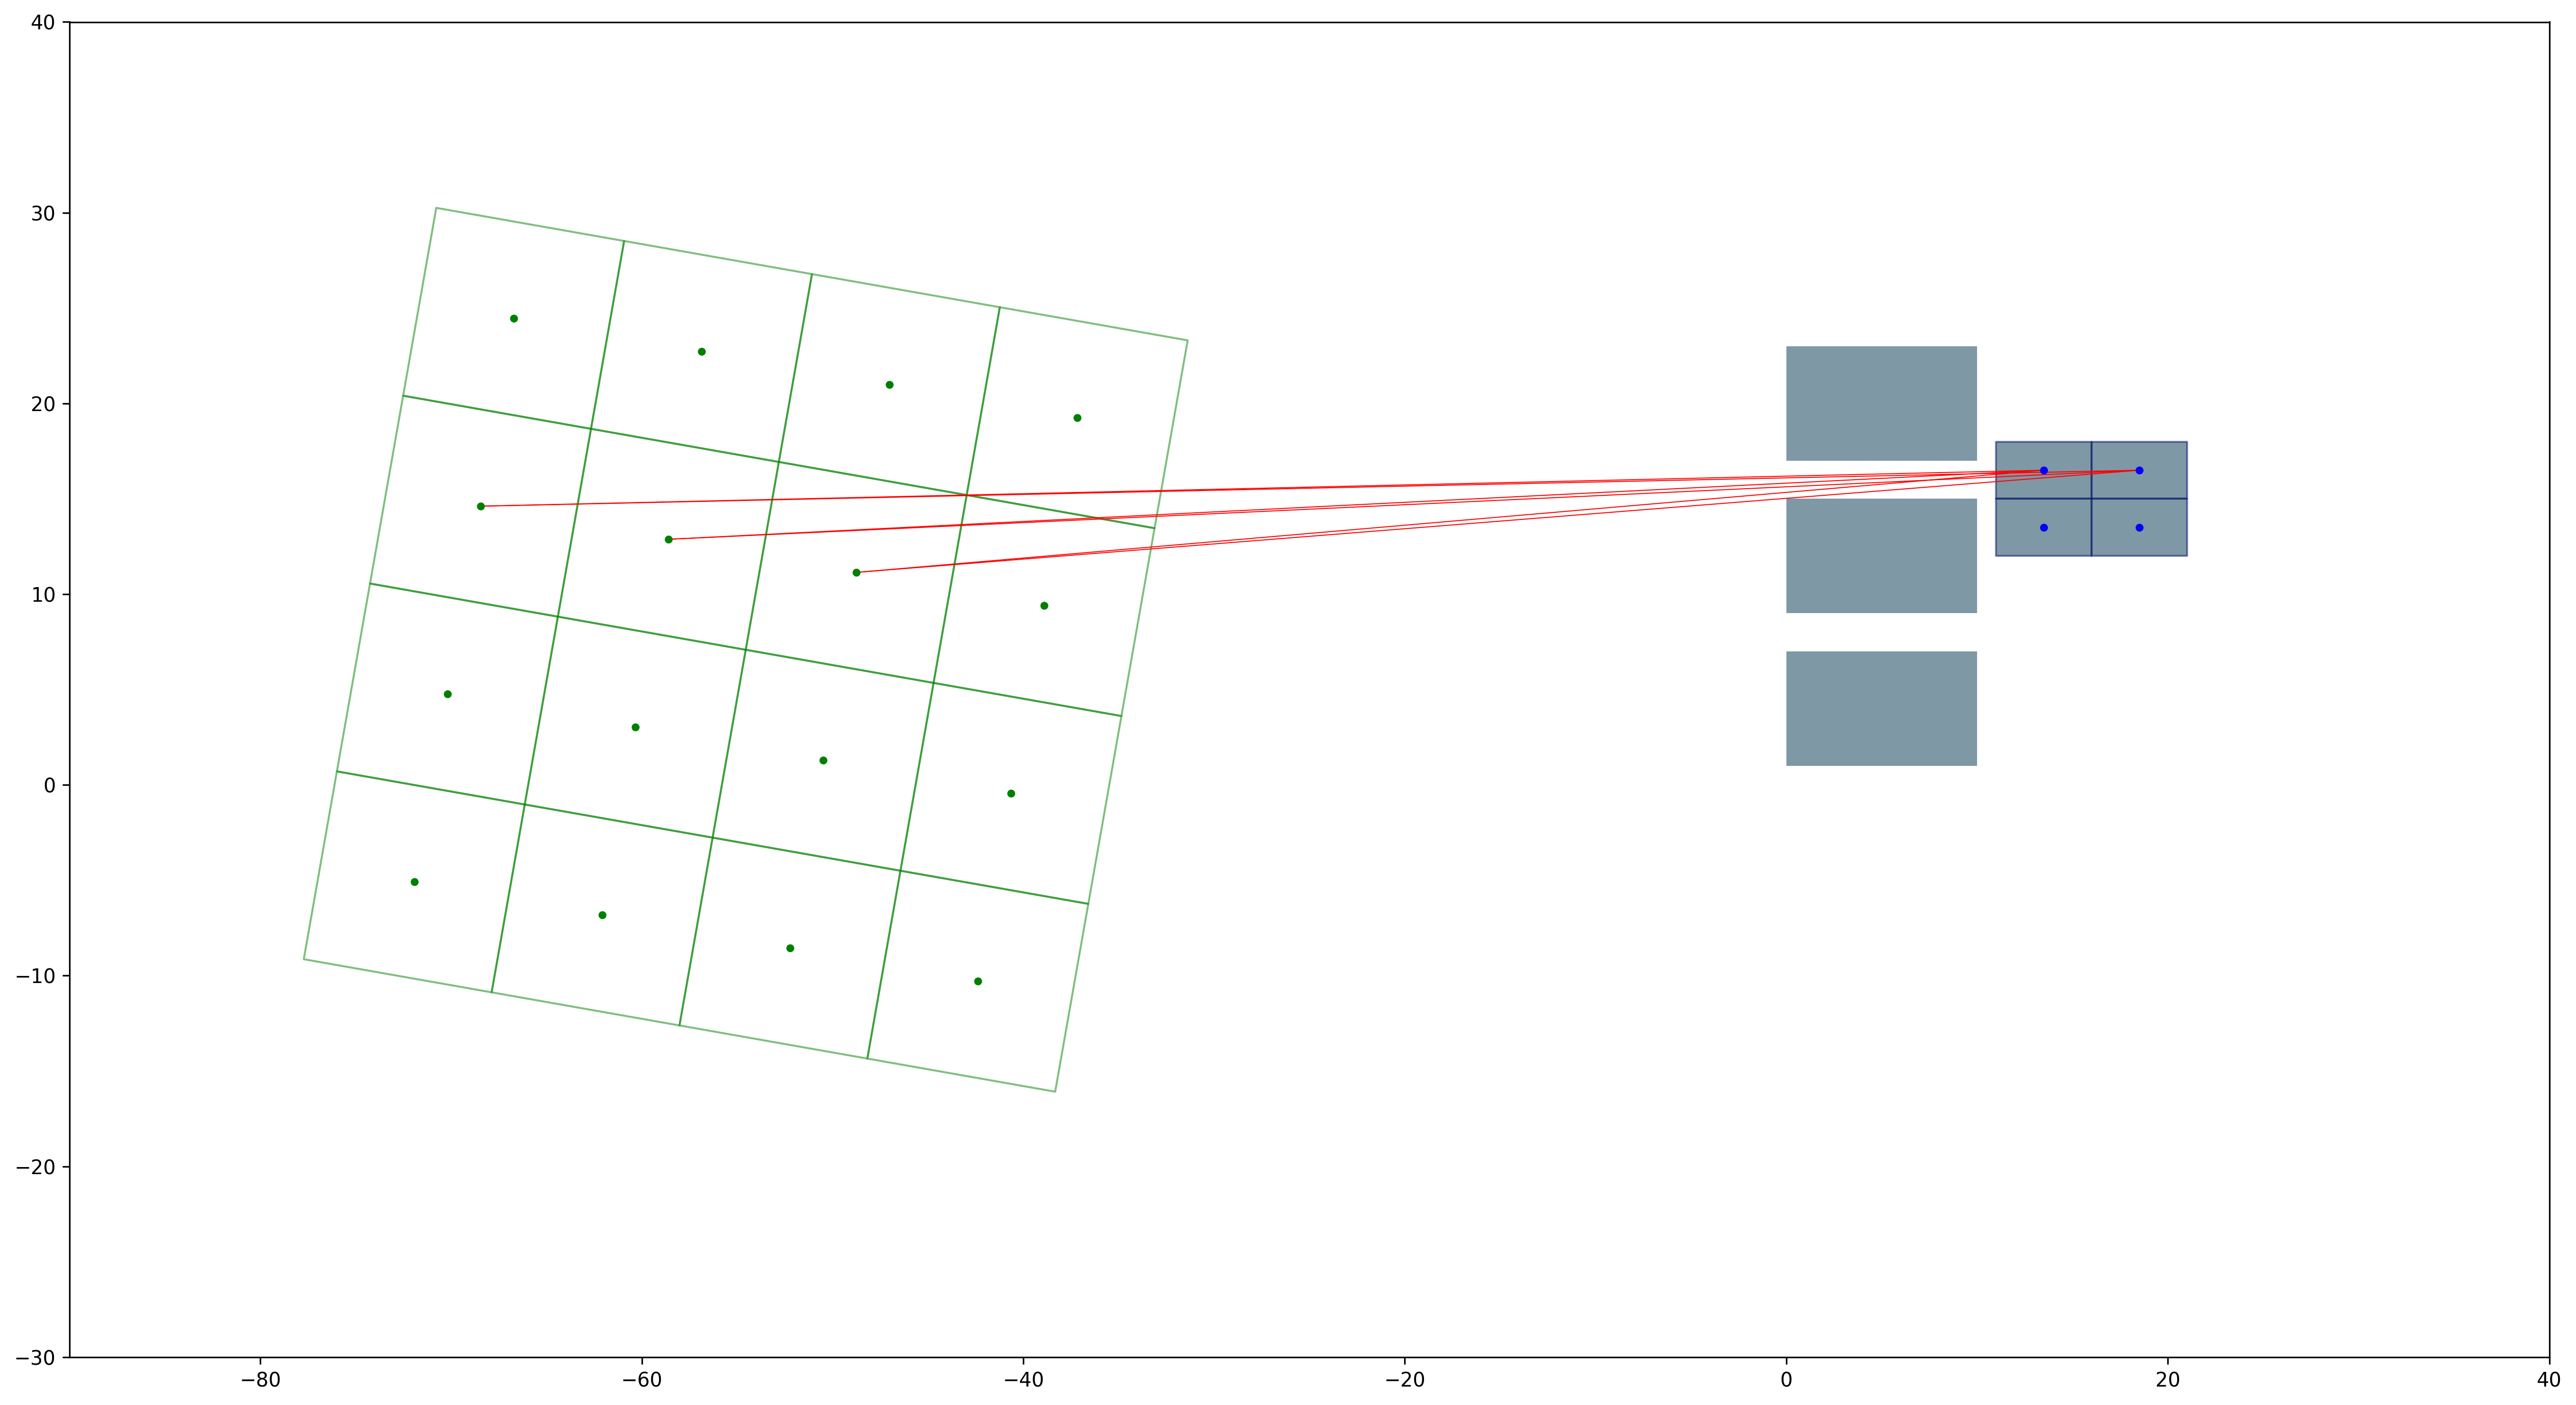

In [8]:
det_subdiv_list = [
    mpl.patches.Rectangle(
        xy[:2] - det_subdivs["incs"][:2] * 0.5,
        det_subdivs["incs"][0],
        det_subdivs["incs"][1],
    )
    for xy in pBs
]
subdiv_inc = np.array(
    [
        config["mmpvx"][0] / config["img nsub"][0],
        config["mmpvx"][1] / config["img nsub"][1],
    ]
)
img_subdiv_list = [
    mpl.patches.Rectangle(
        xy - subdiv_inc * 0.5,
        subdiv_inc[0],
        subdiv_inc[1],
        angle=-angle_deg,
        rotation_point=(xy[0], xy[1]),
    )
    for xy in pAs[:, :2]
]

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
pc = mpl.collections.PatchCollection(img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="none")
pc1 = mpl.collections.PatchCollection(det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc="none")


idx = 0
ts = np.array([pymatcal.findt_2d(geom, abpairs) for geom in blocks])
passIndx = np.all(np.all(ts == 0, axis=2),axis=0)

for pair in abpairs[passIndx]:
    ax.plot(pair[0::3], pair[1::3], "-", c="r", ms=10, lw=0.5, zorder=12)
    idx += 1

block_list = [
    mpl.patches.Rectangle((geom[0], geom[2]), geom[1] - geom[0], geom[3] - geom[2])
    for geom in config["det geoms"]
]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0, 0.2, 0.3, 0.5), ec="none", zorder=10
)
ax.add_collection(pc2)
ax.plot(pAs[:, 0], pAs[:, 1], ".", color=(0, 0.5, 0, 1), ms=6,zorder=15)
ax.plot(pBs[:, 0], pBs[:, 1], ".", color=(0, 0, 1, 1), ms=6,zorder=15)
pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
ax.set_xlim(-90, 40)
ax.set_ylim(-30, 40)

ax.add_collection(pc)
ax.add_collection(pc1)
ax.set_aspect("equal")
fig.tight_layout()
# fig.savefig("intersection-2d_2.png", dpi=300)

### Get intersections

In [9]:
intersections_blk = pymatcal.get_intersections_2d(blocks,abpairs)['intersectons']
intersections_det = pymatcal.get_intersections_2d(focus_det,abpairs)['intersectons']

#### Plot only rays passing through openings. 
Decision is based on whether intersection is zero.

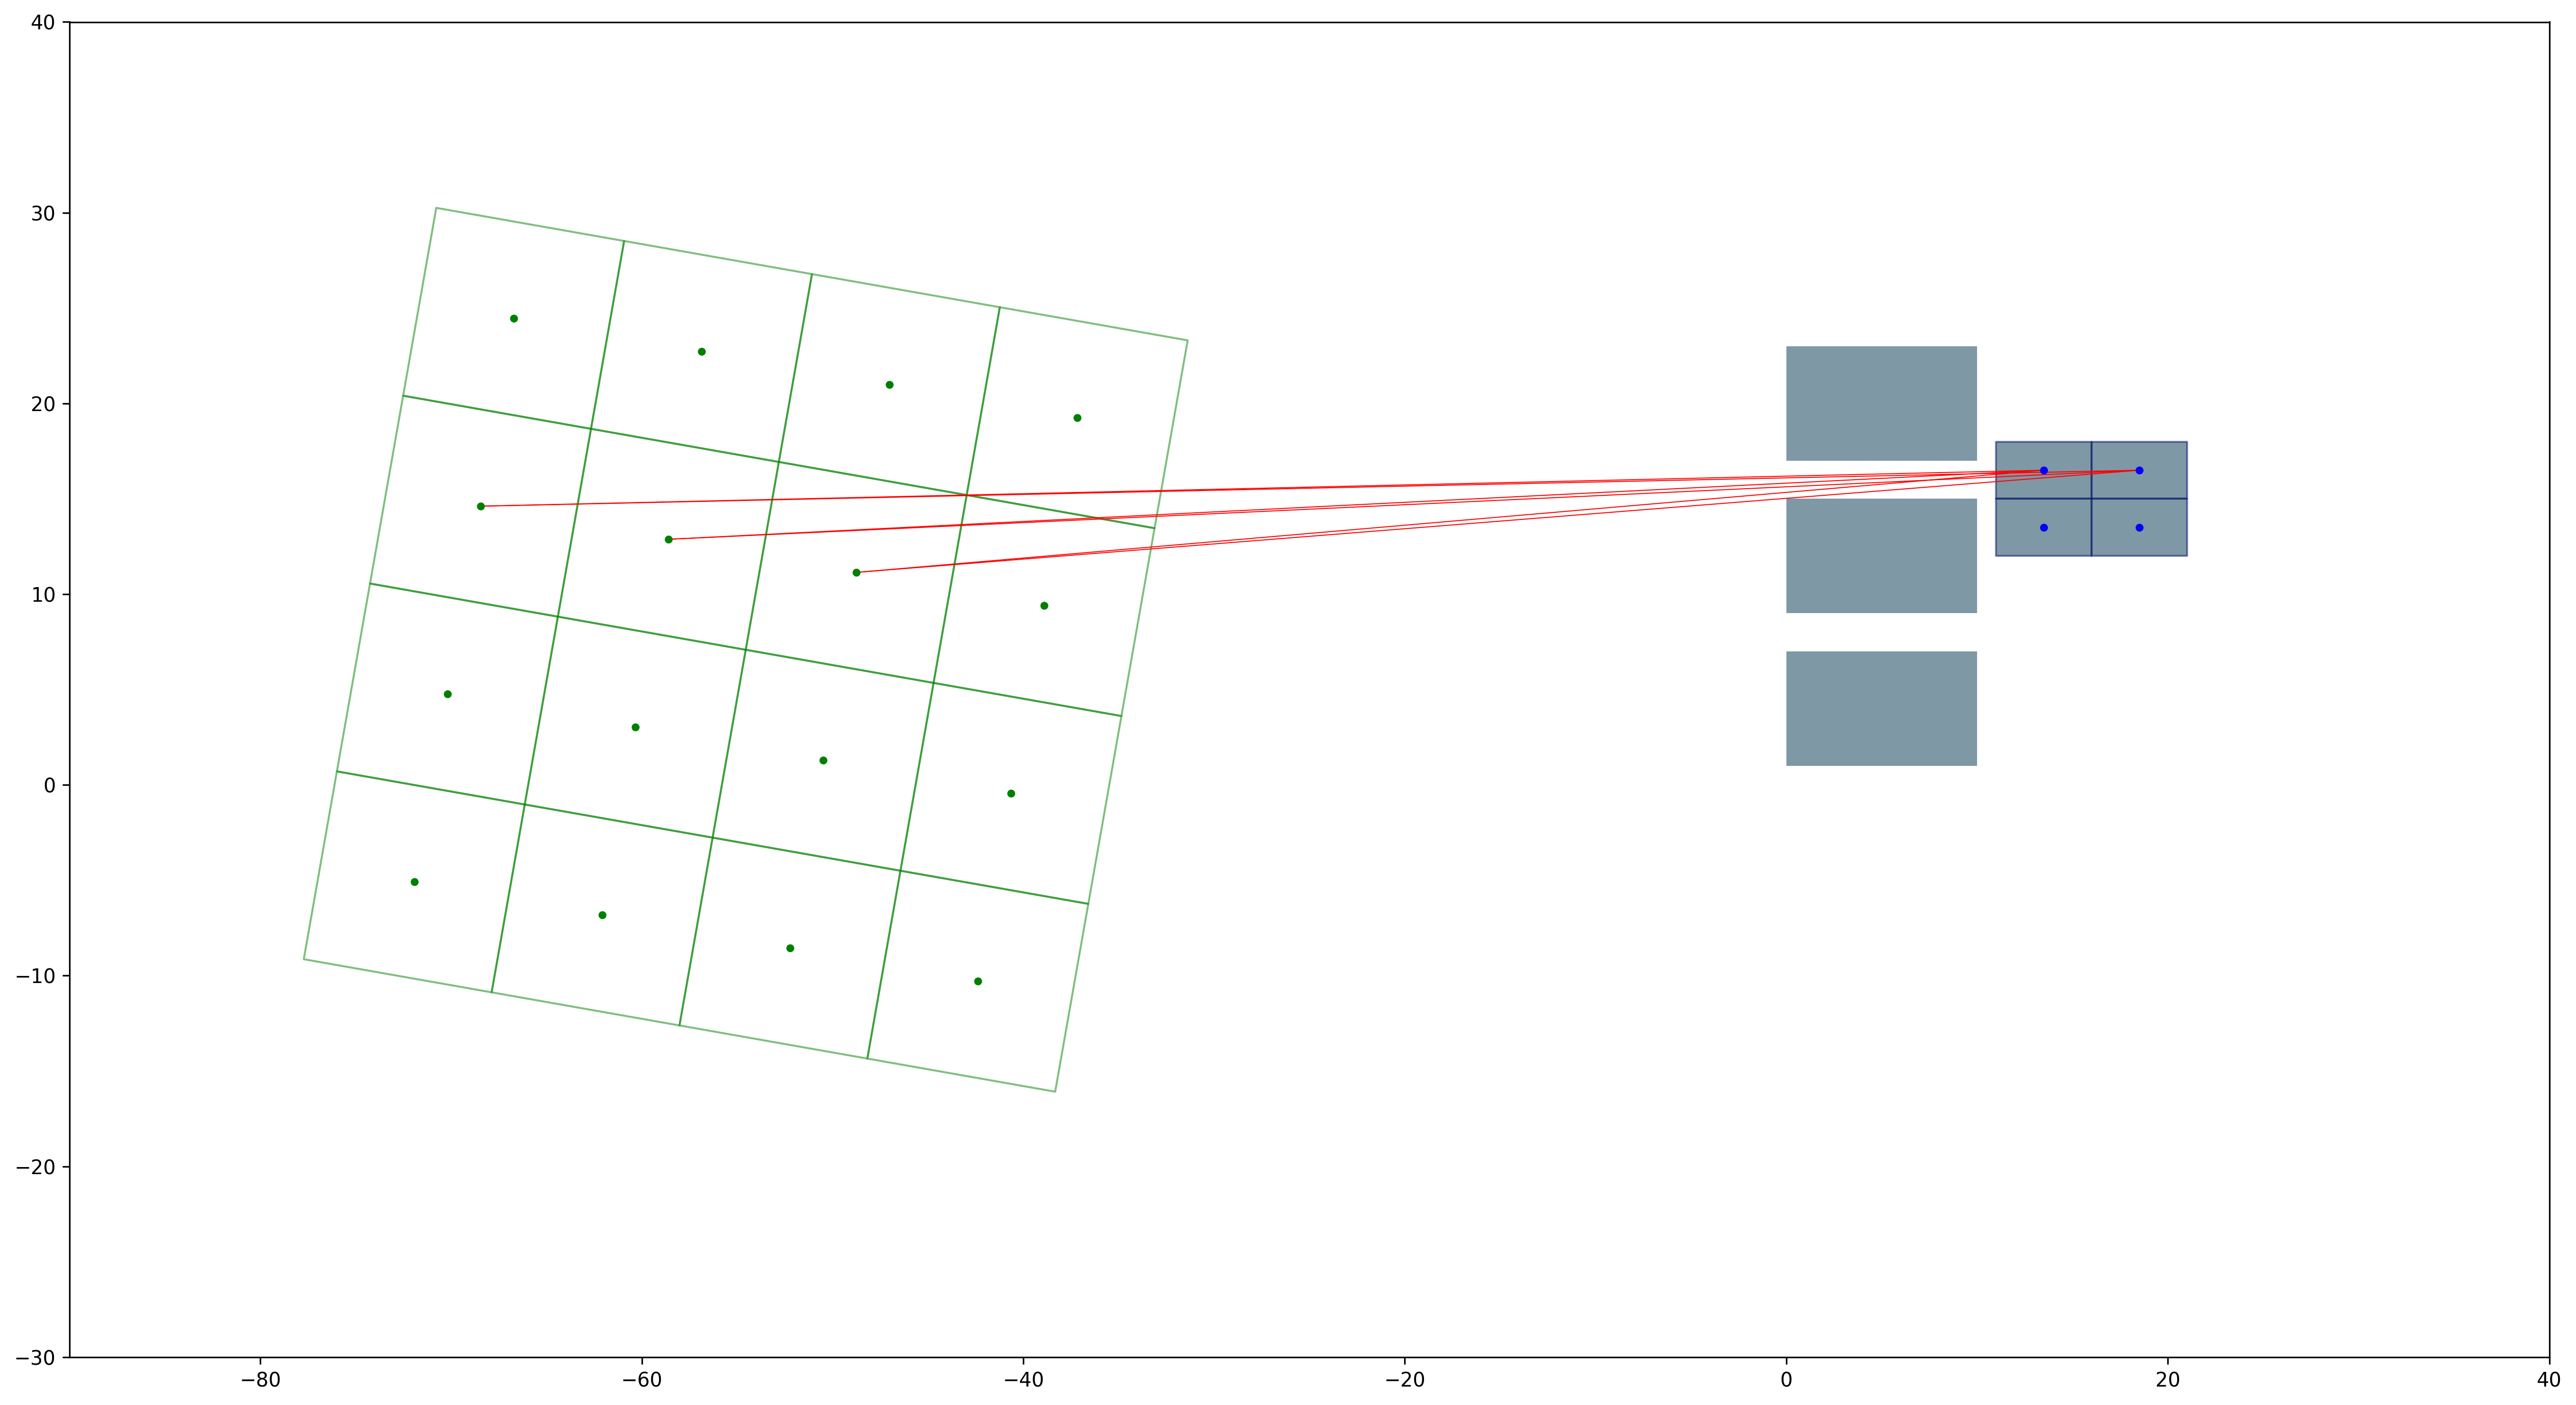

In [10]:
det_subdiv_list = [
    mpl.patches.Rectangle(
        xy[:2] - det_subdivs["incs"][:2] * 0.5,
        det_subdivs["incs"][0],
        det_subdivs["incs"][1],
    )
    for xy in pBs
]
subdiv_inc = np.array(
    [
        config["mmpvx"][0] / config["img nsub"][0],
        config["mmpvx"][1] / config["img nsub"][1],
    ]
)
img_subdiv_list = [
    mpl.patches.Rectangle(
        xy - subdiv_inc * 0.5,
        subdiv_inc[0],
        subdiv_inc[1],
        angle=-angle_deg,
        rotation_point=(xy[0], xy[1]),
    )
    for xy in pAs[:, :2]
]

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
pc = mpl.collections.PatchCollection(img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="none")
pc1 = mpl.collections.PatchCollection(det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc="none")

passIndx = np.all(intersections_blk == 0, axis=0)
idx = 0
for pair in abpairs[passIndx]:
    ax.plot(pair[0::3], pair[1::3], "-", c="r", ms=10, lw=0.5, zorder=12)
    idx += 1

block_list = [
    mpl.patches.Rectangle((geom[0], geom[2]), geom[1] - geom[0], geom[3] - geom[2])
    for geom in config["det geoms"]
]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0, 0.2, 0.3, 0.5), ec="none", zorder=10
)
ax.add_collection(pc2)
ax.plot(pAs[:, 0], pAs[:, 1], ".", color=(0, 0.5, 0, 1), ms=6, zorder=15)
ax.plot(pBs[:, 0], pBs[:, 1], ".", color=(0, 0, 1, 1), ms=6, zorder=15)
pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
ax.set_xlim(-90, 40)
ax.set_ylim(-30, 40)

ax.add_collection(pc)
ax.add_collection(pc1)
ax.set_aspect("equal")
fig.tight_layout()